In [122]:
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
!pip install tqdm

In [123]:
key = 'L49TNJ1SKAPIG4BA'

In [124]:
ts = TimeSeries(key, output_format = 'pandas')
data, meta = ts.get_daily('AAPL', outputsize = 'full')
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
data.columns = columns
print(data)


               Open      High       Low   Close      Volume
date                                                       
2025-07-02  208.910  213.3400  208.1400  212.44  67708479.0
2025-07-01  206.665  210.1865  206.1401  207.82  78788867.0
2025-06-30  202.010  207.3900  199.2607  205.17  91912816.0
2025-06-27  201.890  203.2200  200.0000  201.08  73188571.0
2025-06-26  201.430  202.6400  199.4600  201.00  50799121.0
...             ...       ...       ...     ...         ...
1999-11-05   84.620   88.3700   84.0000   88.31   3721500.0
1999-11-04   82.060   85.3700   80.6200   83.62   3384700.0
1999-11-03   81.620   83.2500   81.0000   81.50   2932700.0
1999-11-02   78.000   81.6900   77.3100   80.25   3564600.0
1999-11-01   80.000   80.6900   77.3700   77.62   2487300.0

[6456 rows x 5 columns]


In [125]:
ti = TechIndicators(key, output_format = 'pandas')
roc, meta = ti.get_roc('')
sma, meta = ti.get_sma('')

ValueError: Invalid API call. Please retry or visit the documentation (https://www.alphavantage.co/documentation/) for ROC.

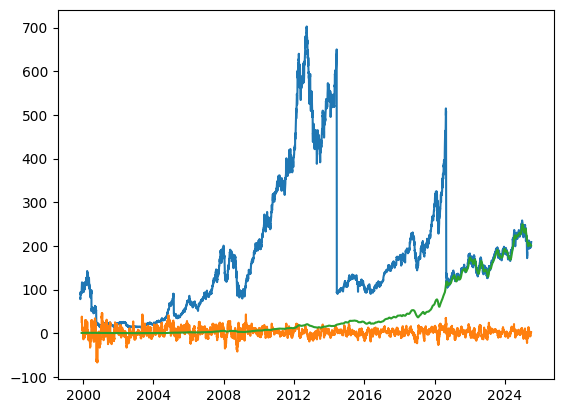

In [126]:
plt.plot(data['Open'])
plt.plot(roc)
plt.plot(sma)

In [127]:

data = data.sort_index()
data['Increase'] = (data['Close'] - data['Close'].shift(7)) / data['Close'].shift(7)
data = data.dropna(subset=['Increase'])
data = data.round(2)

In [128]:
train_data = data.loc['2012-02-01' : '2022-04-06']
test_data = data.loc['2022-04-07' : '2025-01-01']
print(train_data)

              Open    High     Low   Close       Volume  Increase
date                                                             
2012-02-01  458.41  458.99  455.55  456.19    9644500.0      0.07
2012-02-02  455.90  457.17  453.98  455.12    6671300.0      0.08
2012-02-03  457.30  460.00  455.56  459.68   10235700.0      0.03
2012-02-06  458.38  464.98  458.20  463.97    8907600.0      0.04
2012-02-07  465.25  469.75  464.58  468.83   11293700.0      0.05
...            ...     ...     ...     ...          ...       ...
2022-03-31  177.84  178.03  174.40  174.61  103049285.0      0.03
2022-04-01  174.03  174.88  171.94  174.31   78751328.0      0.02
2022-04-04  174.57  178.49  174.44  178.44   76545983.0      0.03
2022-04-05  177.50  178.30  174.42  175.06   70902999.0      0.00
2022-04-06  172.36  173.63  170.13  171.83   89058782.0     -0.02

[2563 rows x 6 columns]


In [129]:
roc = roc.sort_index()
roc = roc.round(0).astype(int)


In [130]:

train_roc = roc.loc['2012-02-01' : '2022-04-06']
test_roc = roc.loc['2022-04-07' : '2025-01-01']


In [131]:
train_data_close = train_data['Close']
print(train_data_close.iloc[0])
test_data_close = test_data['Close']
print(len(train_roc))
print(len(train_data))
print(len(test_roc))
print(len(test_data))  
print(train_roc)

456.19
2563
2563
687
687
            ROC
date           
2012-02-01   11
2012-02-02   10
2012-02-03   10
2012-02-06   10
2012-02-07   11
...         ...
2022-03-31    5
2022-04-01    7
2022-04-04   12
2022-04-05   11
2022-04-06    5

[2563 rows x 1 columns]


In [204]:
# Training parameters
n_training_episodes = 500
learning_rate = 0.7

# Evaluation parameters
n_eval_episodes = 10000

# Environment parameters
env_id = "FrozenLake-v1"
max_steps = 99
gamma = 0.95
eval_seed = []

# Exploration parameters
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.0005

class environment:

    def __init__(self, data, roc):
        self.data = data
        self.roc = roc
        self.balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = 0
        self.trend = None
        self.balance_history = []
        self.price = None
        self.rewards = []
        self.total_reward = 0
        self.total = 100
        self.trades = []

    def step(self, action):

        
        trade = [] 
        if self.index < len(self.data):
            data = self.data
            index = self.index
            
            total = self.get_net_worth()
            holding = (self.num_shares * data.iloc[self.index]) / total
            trade.append(total)
            trade.append(holding)
            trade.append(action)
            
            if action > holding:
                to_buy = (action - holding) * total
                new_balance = self.balance - to_buy
                if new_balance >= 0:
                    
                    new_shares = to_buy / self.data.iloc[self.index]
                    self.balance -= to_buy
                    self.num_shares += new_shares
            elif action < holding:
                to_sell = (holding - action) * total
                shares_to_sell = to_sell / data.iloc[self.index]
                new_num_shares = self.num_shares - shares_to_sell
                if new_num_shares >= 0:
                    self.num_shares = new_num_shares
                    self.balance += to_sell
            trade.append(self.num_shares)
            trade.append(self.balance)
            future_value = (self.num_shares * self.data.iloc[self.index -1]) + self.balance 
            reward = (future_value - total) / total
            trade.append(self.data.iloc[self.index])
            self.index += 1
            self.trades.append(trade)
            self.total_reward += reward
            self.rewards.append(self.total_reward)
            return (reward, False)
        else:
            return (0, True)
        
    def reset(self):
        self.balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = 0
        self.trend = None
        self.balance_history = []
        self.trades = []
    
    def get_net_worth(self):
        
        total = self.balance + (self.num_shares * self.data.iloc[self.index])
        return total
        
    def get_state(self):
        net_worth = self.get_net_worth()
        self.balance_history.append(net_worth)
        return [self.roc["ROC"].iloc[self.index], self.data.iloc[self.index]]


2563
0
[]
2563
1
[0.7117435458516287]
2563
2
[0.7117435458516287, 4.455660589394813]
2563
3
[0.7117435458516287, 4.455660589394813, -1.430736824866863]
2563
4
[0.7117435458516287, 4.455660589394813, -1.430736824866863, 1.6803443684113961]
2563
5
[0.7117435458516287, 4.455660589394813, -1.430736824866863, 1.6803443684113961, 4.43886123724426]
2563
6
[0.7117435458516287, 4.455660589394813, -1.430736824866863, 1.6803443684113961, 4.43886123724426, 1.6018876108084152]
2563
7
[0.7117435458516287, 4.455660589394813, -1.430736824866863, 1.6803443684113961, 4.43886123724426, 1.6018876108084152, 1.86681641725326]
2563
8
[0.7117435458516287, 4.455660589394813, -1.430736824866863, 1.6803443684113961, 4.43886123724426, 1.6018876108084152, 1.86681641725326, 4.429066892715346]
2563
9
[0.7117435458516287, 4.455660589394813, -1.430736824866863, 1.6803443684113961, 4.43886123724426, 1.6018876108084152, 1.86681641725326, 4.429066892715346, 1.8323805728925737]


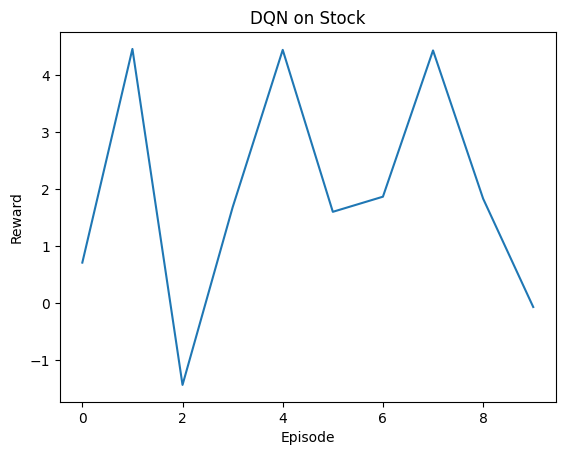

In [212]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

# Create the Stock Environment
env = environment(train_data_close, train_roc)

# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 10
ACTIONS = [0,0.5,1]

# Initialize Q-networks
input_dim = 2
output_dim = 3
policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

# Function to choose action using epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.choice(ACTIONS)  # Explore
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()  # Exploit

# Function to optimize the model using experience replay
def optimize_model():
    if len(memory) < batch_size:
        return
    
    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch = zip(*batch)

    state_batch = torch.FloatTensor(state_batch)
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    

    # Compute Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Main training loop
rewards_per_episode = []
steps_done = 0

for episode in range(episodes):
    state = env.get_state()
    episode_reward = 0
    done = False
    i = 0
    print(len(train_data_close))
    for i in range(len(train_data_close) - 1):
        # Select action
        action = select_action(state, epsilon)
        reward, done = env.step(action)
        

        next_state = env.get_state()
        # Store transition in memory
        memory.append((state, action, reward, next_state))
        
        # Update state
        state = next_state
        episode_reward += reward
        
        # Optimize model
        optimize_model()

        # Update target network periodically
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        steps_done += 1

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    env.reset()
    print(episode)
    print(rewards_per_episode)
    rewards_per_episode.append(episode_reward)

# Plotting the rewards per episode
import matplotlib.pyplot as plt
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN on Stock')
plt.show()

In [ ]:
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN on CartPole')
plt.show()

In [207]:
def test(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps):
    
    # Reset the environment
    env.reset()  
    state = env.get_state()
    step = 0
    done = False
    action_history = []
    sum = 0
    
    while env.index < (len(env.data) - 7):
       
     
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
            action_index = torch.argmax(q_values).item()
            
            action = ACTIONS[action_index]

        reward, done = env.step(action)
        sum += 1
        print(action)
        
        state = env.get_state()

        if done:
            break
         
        new_state = env.get_state()
           
    
           
            
          
          
    
            # If done, finish the episode
        if done:
            break
         
        # Our state is the new state
        state = new_state
    #print(action_history)
    print(sum)
   

In [208]:
test_env = environment(test_data_close, test_roc)
test(n_training_episodes, min_epsilon, max_epsilon, decay_rate, test_env, max_steps)

0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


In [209]:
print(len(test_env.balance_history))
print(len(test_data))
print(test_data)

1361
687
              Open    High     Low   Close      Volume  Increase
date                                                            
2022-04-07  171.16  173.36  169.85  172.14  77594650.0     -0.04
2022-04-08  171.78  171.78  169.20  170.09  76575508.0     -0.04
2022-04-11  168.71  169.03  165.50  165.75  72246706.0     -0.05
2022-04-12  168.02  169.87  166.64  167.66  79265181.0     -0.04
2022-04-13  167.39  171.04  166.77  170.40  70618925.0     -0.05
...            ...     ...     ...     ...         ...       ...
2024-12-24  255.49  258.21  255.29  258.20  23234705.0      0.04
2024-12-26  258.19  260.10  257.63  259.02  27262983.0      0.03
2024-12-27  257.83  258.70  253.06  255.59  42355321.0      0.01
2024-12-30  252.23  253.50  250.75  252.20  35557542.0      0.02
2024-12-31  252.44  253.28  249.43  250.42  39480718.0      0.00

[687 rows x 6 columns]


In [210]:
dates = pd.bdate_range(start='2022-04-07', periods=len(test_env.balance_history))
balances = pd.DataFrame({'Date': dates, 'Balance': test_env.balance_history})
balances.set_index('Date', inplace=True)
print(balances)

               Balance
Date                  
2022-04-07  100.000000
2022-04-08   99.404554
2022-04-11   99.404554
2022-04-12   98.136356
2022-04-13   98.136356
...                ...
2027-06-18  122.994112
2027-06-21  123.425497
2027-06-22  123.425497
2027-06-23  124.586672
2027-06-24  124.586672

[1361 rows x 1 columns]


In [185]:
print(test_env.trades)

[[100.0, 0.0, 0, 0, 100, 172.14], [100.0, 0.0, 0, 0, 100, 170.09], [100.0, 0.0, 0, 0, 100, 165.75], [100.0, 0.0, 0, 0, 100, 167.66], [100.0, 0.0, 0, 0, 100, 170.4], [100.0, 0.0, 0, 0, 100, 165.29], [100.0, 0.0, 0, 0, 100, 165.07], [100.0, 0.0, 0, 0, 100, 167.4], [100.0, 0.0, 0, 0, 100, 167.23], [100.0, 0.0, 0, 0, 100, 166.42], [100.0, 0.0, 0, 0, 100, 161.79], [100.0, 0.0, 0, 0, 100, 162.88], [100.0, 0.0, 0, 0, 100, 156.8], [100.0, 0.0, 0, 0, 100, 156.57], [100.0, 0.0, 0, 0, 100, 163.64], [100.0, 0.0, 0, 0, 100, 157.65], [100.0, 0.0, 0, 0, 100, 157.96], [100.0, 0.0, 0, 0, 100, 159.48], [100.0, 0.0, 0, 0, 100, 166.02], [100.0, 0.0, 0, 0, 100, 156.77], [100.0, 0.0, 0, 0, 100, 157.28], [100.0, 0.0, 1, 0.6576351440220966, 0.0, 152.06], [101.61120610285413, 1.0, 1, 0.6576351440220966, 0.0, 154.51], [96.34354859923714, 1.0, 1, 0.6576351440220966, 0.0, 146.5], [93.75246613179009, 1.0, 1, 0.6576351440220966, 0.0, 142.56], [96.74470603709064, 1.0, 1, 0.6576351440220966, 0.0, 147.11], [95.7122188

In [186]:
print((test_env.balance_history[-1] - test_env.balance_history[0]) / test_env.balance_history[0])

0.15897747954147476


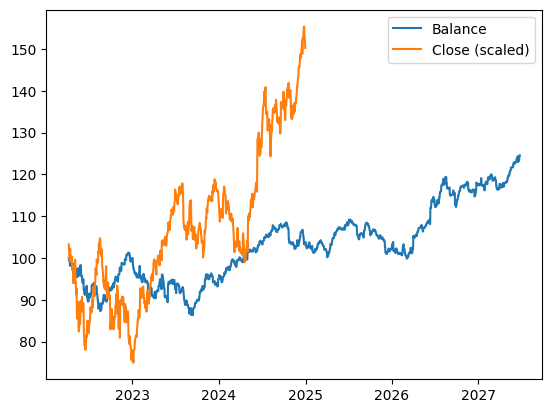

In [211]:
plt.plot(balances, label="Balance")
plt.plot(test_data["Close"] * 0.6, label="Close (scaled)")
plt.legend()
plt.show()


In [79]:
test_increase_array = []
test_history_array = []
num = 0
for i in range(100):
    print(num)
    num += 1
    env = environment(train_data_close, train_roc)
    q_table = pd.DataFrame(0.0, index = states, columns = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    Qtable = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table)
    test_env = environment(test_data_close, test_roc)
    test(n_training_episodes, min_epsilon, max_epsilon, decay_rate, test_env, max_steps, q_table)
    test_increase_array.append((test_env.balance_history[-1] - test_env.balance_history[0]) / test_env.balance_history[0])
    test_history_array.append(test_env.balance_history)
print(test_increase_array)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


KeyboardInterrupt: 

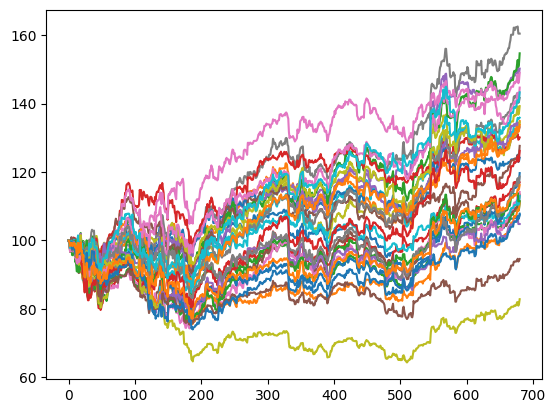

In [80]:
for i in test_history_array:
    plt.plot(i)

plt.show()

In [81]:
underlying_increase = (test_data["Close"][-8] - test_data["Close"][0]) / test_data["Close"][0]
print(underlying_increase)

0.45108632508423385


/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_1521/3728066726.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  underlying_increase = (test_data["Close"][-8] - test_data["Close"][0]) / test_data["Close"][0]


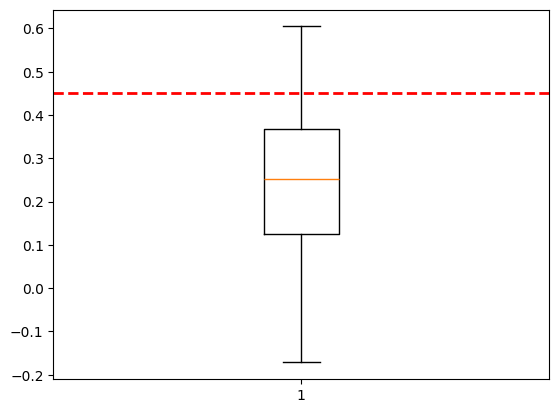

In [82]:
plt.boxplot(test_increase_array)
plt.axhline(y=underlying_increase, color='red', linestyle='--', linewidth=2)
plt.show()

In [18]:
import sys
sys.executable


'/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/bin/python'

In [19]:
# Activate your environment (or use base if you're not using one)
python3 -m ipykernel install --user --name=myenv --display-name "Python (myenv)"

SyntaxError: invalid syntax (468560291.py, line 2)